In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
categorical_features = ['schedule', 'city_id']

In [ ]:
one_hot = OneHotEncoder()


In [ ]:
transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)],
                                 remainder='passthrough'
                                 )

In [ ]:
transformed_df = transformer.fit_transform(sal_df)

In [ ]:
transformed_df = pd.DataFrame(transformed_df, columns=transformer.get_feature_names())

# Regular EDA and plotting libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plot to appear inside the notebook

In [14]:
%matplotlib inline

# Models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay as plot_roc_curve
from sklearn.preprocessing import OneHotEncoder

# Embedding

In [15]:
!pip install compress-fasttext[full]

  Preparing metadata (setup.py) ... done
  Created wheel for compress-fasttext: filename=compress_fasttext-0.1.4-py3-none-any.whl size=16096 sha256=30e0969248aee04da9920d6efe550d36efe74184ecbf83abc60c0d295f83cca6
  Stored in directory: /root/.cache/pip/wheels/ef/0f/e8/5873a842310e96066067d9300281979b4a7d74b46d938f440e
Successfully built compress-fasttext


In [ ]:
import compress_fasttext
small_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/geowac_tokens_sg_300_5_2020-100K-20K-100.bin'
)
print(small_model['спасибо'])
print(small_model.most_similar('котенок'))

## Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/')

In [5]:
df = pd.read_csv("/content/drive/MyDrive/data_vacancies.csv")

In [ ]:
df

In [8]:
df['target'] = df['salary_from']

In [9]:
df['target'].value_counts()

60000    1745
50000    1707
40000    1513
45000     994
30000     966
         ... 
41712       1
44421       1
75200       1
23400       1
92400       1
Name: target, Length: 779, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19489 entries, 0 to 19488
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   19489 non-null  int64 
 1   custom_position      19489 non-null  object
 2   schedule             19489 non-null  object
 3   salary_from          19489 non-null  int64 
 4   salary_to            19489 non-null  int64 
 5   salary_pay_type      106 non-null    object
 6   offer_education_id   19489 non-null  int64 
 7   education_name       19489 non-null  object
 8   education_is_base    19489 non-null  bool  
 9   education_order_num  19489 non-null  int64 
 10  city_id              19489 non-null  int64 
 11  list_regions         19489 non-null  object
 12  work_skills          19489 non-null  object
 13  tags_id              13490 non-null  object
 14  target               19489 non-null  int64 
dtypes: bool(1), int64(7), object(7)
memory usage: 2.1+ MB

In [11]:
df.columns

Index(['id', 'custom_position', 'schedule', 'salary_from', 'salary_to',
       'salary_pay_type', 'offer_education_id', 'education_name',
       'education_is_base', 'education_order_num', 'city_id', 'list_regions',
       'work_skills', 'tags_id', 'target'],
      dtype='object')

In [12]:
sal_df = df[['custom_position', 'schedule', 'city_id', 'target']]

In [13]:
sal_df.describe()

,city_id,target
count,19489.000000,19489.000000
mean,22.559495,58869.138848
std,38.693556,30248.195246
min,1.000000,20500.000000
25%,1.000000,40000.000000
50%,2.000000,50000.000000
75%,57.000000,70000.000000
max,272.000000,750000.000000


In [17]:
def get_argmax_vector(value):
  """Returns the argmax of the vector representation of the given value."""
  vector = small_model.get_vector(value)
  argmax = np.argmax(vector)
  return argmax

In [21]:
sal_df['custom_position'] = sal_df['custom_position'].apply(get_argmax_vector)

<ipython-input-21-200cf6735343>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sal_df['custom_position'] = sal_df['custom_position'].apply(get_argmax_vector)


In [23]:
sal_df

,custom_position,schedule,city_id,target,custom_position_
0,187,полный рабочий день,2,60000,187
1,122,полный рабочий день,2,60000,122
2,187,полный рабочий день,2,60000,187
3,268,частичная занятость,1,30000,268
4,268,частичная занятость,57,30000,268
...,...,...,...,...,...
19484,209,полный рабочий день,1,45000,209
19485,14,сменный график,1,35000,14
19486,173,полный рабочий день,1,77000,173
19487,213,полный рабочий день,2,80000,213


# OneHotEncoding function - (schedule + city_id)

In [24]:
def one_hot_encoding(df, column1, column2):

    # Select columns to encode
    data_to_encode = df[[column1, column2]]

    # One Hot Encoding using get_dummies
    encoded_data_1 = pd.get_dummies(data_to_encode, columns=[column1])

    # One Hot Encoding of the Top-5 regions in the "city_id" column
    top5_cities = df['city_id'].value_counts().nlargest(5).index
    encoded_data_2 = pd.get_dummies(df['city_id'][df['city_id'].isin(top5_cities)], prefix='region')

    # Merge encoded data with original data
    df_encoded = pd.concat([df, encoded_data_1, encoded_data_2], axis=1)

    # Delete original text column
    df_encoded = df_encoded.drop(columns=[column1, column2])

    return df_encoded

df_encoded = one_hot_encoding(sal_df, 'schedule', 'city_id')
df_encoded

,custom_position,target,custom_position_,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,region_1,region_2,region_57,region_102,region_174
0,187,60000,187,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1,122,60000,122,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
2,187,60000,187,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
3,268,30000,268,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
4,268,30000,268,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19484,209,45000,209,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19485,14,35000,14,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0
19486,173,77000,173,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19487,213,80000,213,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0


In [30]:
df = df_encoded

# Modeling

In [41]:
df = df.drop('custom_position_', axis=1)

In [45]:
df

,custom_position,target,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,region_1,region_2,region_57,region_102,region_174
0,187,60000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1,122,60000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
2,187,60000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
3,268,30000,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
4,268,30000,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19484,209,45000,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19485,14,35000,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0
19486,173,77000,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19487,213,80000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0


In [47]:
number_of_nan_values = df.isnull().sum().sum()
print("There are", number_of_nan_values, "NaN values in the DataFrame.")

There are 5370 NaN values in the DataFrame.


In [49]:
df.dropna(inplace=True)

In [51]:
df

,custom_position,target,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,region_1,region_2,region_57,region_102,region_174
0,187,60000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1,122,60000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
2,187,60000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
3,268,30000,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
4,268,30000,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19484,209,45000,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19485,14,35000,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0
19486,173,77000,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19487,213,80000,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0


In [52]:
# Split data into X and Y
X = df.drop('target', axis=1)

y = df['target']

In [53]:
X

,custom_position,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,region_1,region_2,region_57,region_102,region_174
0,187,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
1,122,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
2,187,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
3,268,0,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0
4,268,0,0,0,0,0,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19484,209,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19485,14,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0
19486,173,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
19487,213,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0


In [54]:
y

0        60000
1        60000
2        60000
3        30000
4        30000
         ...  
19484    45000
19485    35000
19486    77000
19487    80000
19488    80000
Name: target, Length: 18415, dtype: int64

In [55]:
# Split data into train and test sets
np.random.seed(42)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
X_train

,custom_position,schedule_вахта,schedule_полный рабочий день,schedule_свободный график,schedule_сменный график,schedule_удаленная работа,schedule_частичная занятость,region_1,region_2,region_57,region_102,region_174
7475,156,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0
13556,268,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1048,170,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
17702,10,0,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3194,187,0,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11682,2,0,0,0,1,0,0,1.0,0.0,0.0,0.0,0.0
12374,187,0,1,0,0,0,0,0.0,1.0,0.0,0.0,0.0
5586,187,0,0,0,0,1,0,1.0,0.0,0.0,0.0,0.0
894,199,0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0


In [57]:
y_train

7475      22400
13556     60000
1048     120000
17702     40000
3194      30000
          ...  
11682     44226
12374     55000
5586      32000
894       84800
16620    150000
Name: target, Length: 14732, dtype: int64

In [58]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """Fits and evaluate given machine learning models.
    Parameters:
    models : a dict of different Scikit-Learn machine learning Models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training data
    y_test : testing data

    Returns:
    A dictionary of models and their scores
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}

    # Loop through models
    for name, model in models.items():
        # Fit model to the data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to the model_scores dictionary
        model_scores[name] = model.score(X_test, y_test)

    return model_scores

In [59]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test
                             )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
model_scores

{'Logistic Regression': 0.09693184903611186,
 'KNN': 0.11159380939451534,
 'Random Forest': 0.15829486831387457}

## Model Comparison

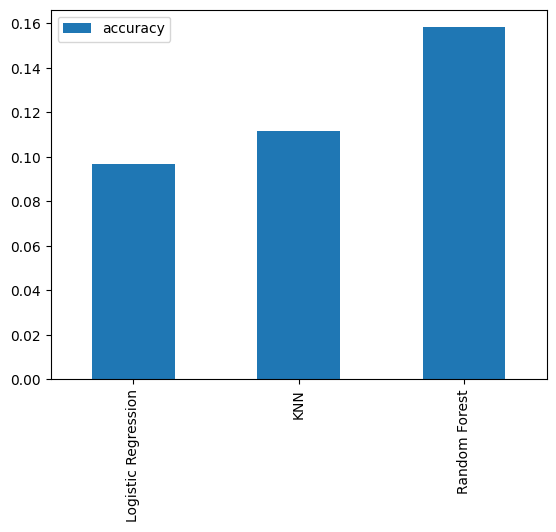

In [61]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])

model_compare.T.plot.bar();

Now we've got a baseline model and we know that we should tune hyper parameters accordingly.

Let's look at the following:

* hyperparameters tuning
* Features importance
* confusion matrix
* Cross validation
* Precision
* Recall
* F1 score
* Classification Report
* ROC curve
* Area Under the Curve (AUC)

## Hyperparameter Tuning

In [62]:
# Let's tune the KNN

train_scores = []
test_scores = []

# Create a list of different for n_neighbors
neighbors = range(1, 21)

# Set up KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors = i)

    # Fit the algorithm
    knn.fit(X_train, y_train)

    # Update the train scores list
    train_scores.append(knn.score(X_train, y_train))

    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

In [63]:
train_scores

[0.15177844148791747,
 0.14960629921259844,
 0.14763779527559054,
 0.14621232690741243,
 0.15374694542492534,
 0.15490089600868856,
 0.15456149877816996,
 0.15381482487102904,
 0.15333966874830302,
 0.15137116481129514,
 0.1581591094216671,
 0.15917730111322292,
 0.16073852837360847,
 0.16236763508009774,
 0.16162096117295682,
 0.16073852837360847,
 0.16107792560412706,
 0.1639288623404833,
 0.1622318761878903,
 0.16610100461580232]

In [64]:
test_scores

[0.1004615802335053,
 0.09747488460494162,
 0.09937550909584578,
 0.10399131143089872,
 0.11159380939451534,
 0.11267988053217486,
 0.11403746945424925,
 0.11295139831658974,
 0.11458050502307901,
 0.1134944338854195,
 0.12191148520228075,
 0.12707032310616345,
 0.12625576975291883,
 0.13005701873472714,
 0.12897094759706762,
 0.12924246538148249,
 0.1333152321477057,
 0.13630192777626934,
 0.13548737442302472,
 0.13793103448275862]

Maximum KNN score on the test data: 13.79%


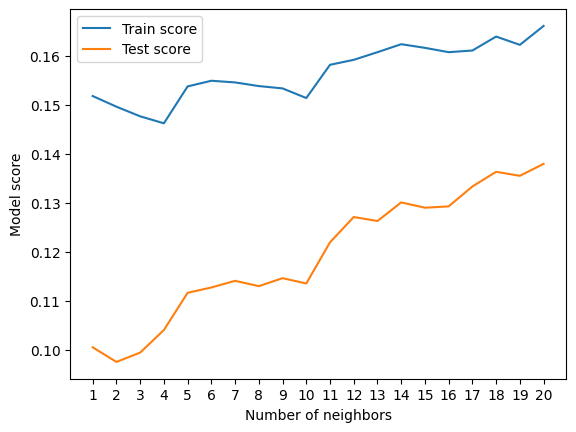

In [65]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

# Hyperparameter tuning with RandomizedSerachCV

We are going to tune:
* LogisticRegression()
* RandomForestClassifier()

...using RandomizedSerachCV

In [66]:
# Create a hyperparameter grid for Logistic Regression

log_reg_grid = {"C": np.logspace(-4, 4, 20), "solver": ["liblinear"]}

# Create a hyperparameter grid for Random Forest Classifier

rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3,5, 10], "min_samples_split": np.arange(2, 20, 2), "min_samples_leaf": np.arange(1, 22, 2)}

Now we've got hyperparameters grids for each of our models.
let's tune them using RandomizedSearchCV

In [67]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameters search for logistic regression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5, n_iter=20, verbose=True)

# Fit random hyperparameters search model for logistic regression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [68]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 29.763514416313132}

In [69]:
rs_log_reg.score(X_test, y_test)

0.12571273418408907

Now that we've tuned the LogisticRegression let's do the same for RandomForestClassifier()

In [70]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameters search for random forest classifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5, n_iter=20, verbose=True)

# Fit random hyperparameters search model for model RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [71]:
# Fit the best hyperparameters
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [72]:
# Evaluate the randomize search random forest classifier model
rs_rf.score(X_test, y_test)

0.15585120825414064

In [73]:
model_scores

{'Logistic Regression': 0.09693184903611186,
 'KNN': 0.11159380939451534,
 'Random Forest': 0.15829486831387457}

## Hyperparameter tuning with GridSearchCV

In [ ]:
# Diferent Hyperparameters for our Logistic Regression model

log_reg_grid = {"C": np.logspace(-4, 4, 30), "solver": ["liblinear"]}

# Set up the grid hyperparameter search for logistic regression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit ou grid parameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
# Check the best hyperparameter
gs_log_reg.best_params_

In [ ]:
# Evaluate the grid search LogisticRegressionModel
gs_log_reg.score(X_test, y_test)

## Evaluating our tuned machine learning classifier, beyond accuracy

* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

... and it will be great if cross-validation was used where possible

To make comparisons and evaluate our trained model, first we need to make predictions.

In [ ]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)

In [ ]:
y_preds

In [ ]:
y_test

In [ ]:
# Plot ROC curve and calculate AUC metric
from sklearn.metrics import RocCurveDisplay

gs_log_reg_disp = RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test)

In [ ]:
# Confusion matrix
confusion_matrix(y_test, y_preds)

In [ ]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """Plot confusion matrix using Seaborn's heatmap
    """

    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

plot_conf_mat(y_test, y_preds)

In [ ]:
print(classification_report(y_test, y_preds))

# Calculate evaluation metrics using Cross Validation

To do so, we'll be using `cross_val_score()`.

In [ ]:
# Check best hyperparameter
gs_log_reg.best_params_

In [ ]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=0.20433597178569418, solver='liblinear')

In [ ]:
# Cross Validated accuracy
from sklearn.model_selection import cross_val_score
cv_acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
cv_acc

In [ ]:
cv_acc = np.mean(cv_acc)
cv_acc

In [ ]:
# Cross validated precision
cv_precision = cross_val_score(clf, X, y, cv=5, scoring="precision")
cv_precision = np.mean(cv_precision)
cv_precision

In [ ]:
# Cross validated recall
cv_recall = cross_val_score(clf, X, y, cv=5, scoring="recall")
cv_recall = np.mean(cv_recall)
cv_recall

In [ ]:
# Cross validated F1
cv_f1 = cross_val_score(clf, X, y, cv=5, scoring="f1")
cv_f1 = np.mean(cv_f1)
cv_f1

In [ ]:
# Vizualize cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc, "Precision": cv_precision, "Recall": cv_recall, "F1": cv_f1}, index=[0])

cv_metrics.T.plot.bar(title="Cross-validated classification metrics", legend=False);

### Feature Importance

Feature Importance is another as asking, "which feature contributed most to the model and how did they contribute?"

Finding feature importance is different for each machine learning model. One way to find feature importance is to search for "(MODEL NAME) feature importance."

In [ ]:
# Fits an instance of LogisticRegression
clf = LogisticRegression(C=0.20433597178569418, solver='liblinear')
clf.fit(X_train, y_train);

In [ ]:
clf.coef_

In [ ]:
# Match the features to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

In [ ]:
# Vizualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature importance", legend=False);

In [ ]:
pd.crosstab(df['sex'], df['target'])

In [ ]:
pd.crosstab(df["slope"], df["target"])